In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F

 

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# CIFAR-10 dataset
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

 

 

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=train_transform, download=True)
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=test_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)
 

100%|██████████| 170498071/170498071 [00:03<00:00, 54026177.59it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


In [3]:

# Modified ResNet-18

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
 
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

 

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


In [4]:
class ModifiedResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ModifiedResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.avg_pool = nn.AvgPool2d(kernel_size=8)
        self.Dropout = nn.Dropout(0.5)
        self.linear = nn.Linear(256, num_classes)
 

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)
 

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = self.Dropout(out)
        out = out.view(out.size(0), -1)
        h = x.view(x.shape[0], -1)
        out = self.linear(out)
        return out

In [5]:
# Model
model = ModifiedResNet(BasicBlock, [2, 2, 2, 1]).to(device)
 
# Loss and optimizer
criterion = nn.CrossEntropyLoss()

#optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005,  momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)

In [6]:
print("Number of Trainable parameter:", sum(param.numel() for param in model.parameters() if param.requires_grad))

Number of Trainable parameter: 4024394


In [7]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [9]:
num_epochs = 50
train_accuracy = []
train_loss = []
best_train_loss=0

for epoch in range(num_epochs):
    # Training loop
    epoch_acc = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        # Forward pass
        output = model(images)
        loss = criterion(output, labels)
        acc = calculate_accuracy(output, labels)
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_acc += acc.item()
    scheduler.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Accuracy: {epoch_acc / len(train_loader)}')
    train_accuracy.append(epoch_acc / len(train_loader))
    train_loss.append(loss.item())
    if loss < best_train_loss:
        best_train_loss = loss
        torch.save(model.state_dict(), 'best_model.pt')

    #Test
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    # Print the accuracy
    accuracy = 100 * correct / total
    print(f'Test Accuracy of the model on the 10000 test images: {accuracy:.2f}%')

Epoch [1/50], Loss: 0.8168, Accuracy: 0.550963691618682
Test Accuracy of the model on the 10000 test images: 64.96%
Epoch [2/50], Loss: 0.8284, Accuracy: 0.6066058861164427
Test Accuracy of the model on the 10000 test images: 69.42%
Epoch [3/50], Loss: 1.3985, Accuracy: 0.6853206973768394
Test Accuracy of the model on the 10000 test images: 74.10%
Epoch [4/50], Loss: 0.8950, Accuracy: 0.7274272232885477
Test Accuracy of the model on the 10000 test images: 77.16%
Epoch [5/50], Loss: 1.4419, Accuracy: 0.7552383237364043
Test Accuracy of the model on the 10000 test images: 78.64%
Epoch [6/50], Loss: 0.6946, Accuracy: 0.7752319257837492
Test Accuracy of the model on the 10000 test images: 79.13%
Epoch [7/50], Loss: 0.6990, Accuracy: 0.7905470249520153
Test Accuracy of the model on the 10000 test images: 82.16%
Epoch [8/50], Loss: 0.8772, Accuracy: 0.8023432501599488
Test Accuracy of the model on the 10000 test images: 83.75%
Epoch [9/50], Loss: 0.2957, Accuracy: 0.8142594369801663
Test Acc

In [12]:
print("Number of Trainable parameter:", sum(param.numel() for param in model.parameters() if param.requires_grad))

Number of Trainable parameter: 4024394


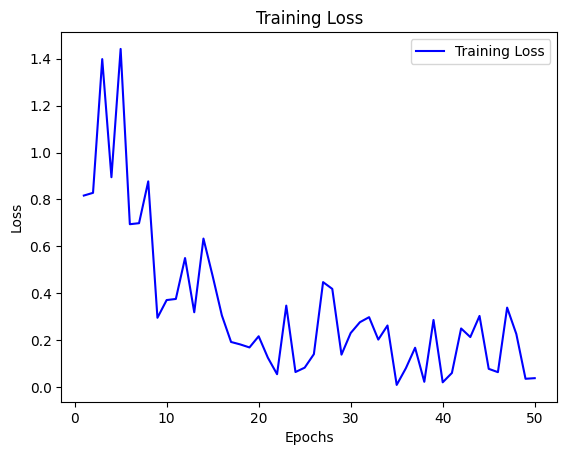

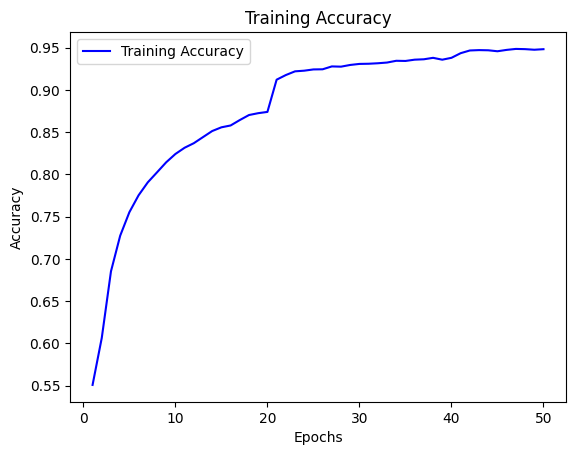

In [13]:
import matplotlib.pyplot as plt
epochs = range(1, len(train_accuracy) + 1)

# Plot train loss
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Plot train accuracy
plt.plot(epochs, train_accuracy, 'b-', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from torchvision.transforms import v2 
import torch.optim as optim
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle

In [15]:
class CIFAR10Dataset(Dataset):
    def __init__(self, base_dir, transform=None, mode='train'):
        self.data = []
        self.labels = []
        self.transform = transform
        self.mode = mode

        if mode == 'train':
            # Loop through the training batch files
            for i in range(1, 6):  # There are five training batches
                file_path = os.path.join(base_dir, f'cifar-10-python/cifar-10-batches-py/data_batch_{i}')
                batch = self.load_cifar_batch(file_path)
                self.data.append(batch[b'data'])
                self.labels += batch[b'labels']
        elif mode == 'validation':
            file_path = os.path.join(base_dir, f'cifar-10-python/cifar-10-batches-py/test_batch')
            batch = self.load_cifar_batch(file_path)
            self.data.append(batch[b'data'])
            self.labels += batch[b'labels']
        elif mode == 'test':
            # Test data is in a separate file without labels
            file_path = os.path.join(base_dir, f'cifar_test_nolabels.pkl')
            batch = self.load_cifar_batch(file_path)
            self.data.append(batch[b'data'])

        # Convert data to a format appropriate for PyTorch: NCHW
        self.data = np.vstack(self.data).reshape(-1, 3, 32, 32).transpose((0, 2, 3, 1))

    @staticmethod
    def load_cifar_batch(file_path):
        with open(file_path, 'rb') as fo:
            batch = pickle.load(fo, encoding='bytes')
        return batch

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]

        if self.transform:
            img = self.transform(img)

        if self.mode == 'train' or self.mode == 'validation':
            return img, self.labels[idx]
        return img

In [16]:
base_dir = '/kaggle/input/deep-learning-mini-project-spring-24-nyu/'
device = "cuda" if torch.cuda.is_available() else "cpu"

batch_size = 32
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test_dataset = CIFAR10Dataset(base_dir=base_dir, transform=transform_test, mode='test')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [17]:
import pandas as pd




def make_predictions(dataloader, model, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for X in dataloader:
            X = X.to(device)
            pred = model(X)
            predicted_labels = pred.argmax(1).cpu().numpy()
            predictions.extend(predicted_labels)

    # Create a DataFrame with the predictions
    submission = pd.DataFrame({
        'ID': range(len(predictions)),
        'Labels': predictions  # Use predictions
    })

    # Save the DataFrame to a CSV file
    submission.to_csv('cifar10_predictions.csv', index=False)
    print("Predictions saved to cifar10_predictions.csv")

make_predictions(test_loader, model, device)

Predictions saved to cifar10_predictions.csv


In [19]:
torch.save(model, 'best_model_full.pth')

In [20]:
# To load the full model:
model = torch.load('best_model_full.pth')
model.eval()  # Don't forget to set the model to evaluation mode

ModifiedResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1,